In [68]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import re
import itertools
#from grepfunc import grep
import numpy as np
import matplotlib.pyplot as plt
import string
import gensim

from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import Data

In [69]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/forWordEmbedding",sep='\t',encoding="ISO-8859-1")
df.head()

,nct_id,type,txt
0,NCT02194751,inclusion,Normal lactic dehydrogenase
1,NCT02194751,inclusion,Largest tumor mass < 7 cm
2,NCT02194751,inclusion,Involvement of < 3 nodal sites with a diameter...
3,NCT02194751,inclusion,No clinically significant pleural effusion or ...
4,NCT02194751,inclusion,Spleen size of â¤ 16 cm by CT scan


Extracting only the inclusion criteria

In [70]:
#Convert test to a list so that it can be cleaned
#t = df['txt'].tolist()
t = df[df.type=="inclusion"].txt.tolist()
len(t)

64644

# Text Processing

## Text Cleaning



### Removing Special Characters, digits & alphanumeric
The text is converted to lower case and numeric and alphanumeric words are removed. Further, to remove articles and small numbers, words of length >3 are kept

In [0]:
#convert to lower case
txt1 = list(map(lambda x: x.lower(), t))
#Keep only non-Alphanumeric [^a-zA-Z0-9_]
txt2 = list(map(lambda x: re.sub(r'\w*\d\w*', " ",x), txt1))
txt3 = list(map(lambda x: re.sub(r'[^a-z ]+', '', x), txt2))
#txt2 = list(map(lambda x: re.sub('\W+', " ",x), txt1))
#Remove words < 4 characters
txt4 = list(map(lambda x: re.sub(r'\b\w{1,3}\b', '', x),txt3))
#Remove Extra Spaces
txt5 = list(map(lambda x: re.sub('\s+', ' ', x).strip(),txt4))

In [72]:
print(t[90:100])
print()
print(txt5[90:100])

['Prior radiation is permitted IF the site(s) of measurable disease has progressed since prior irradiation and radiation is completed at least 2 weeks before initiation of drug treatment (stereotactic radiotherapy excluded)', 'Patients with central nervous system (CNS) metastases are ELIGIBLE, provided that prior to drug treatment, the metastases have been treated, remain clinically or radiographically stable and the patient has no significant neurologic symptoms', 'Patients must NOT have prior malignancy EXCEPT for the following: adequately treated basal cell or squamous cell skin cancer, in situ cervical cancer, adequately treated stage I or II cancer from which the patient is currently in complete remission, or any other cancer from which the patient has been disease-free for >= 3 years', 'Women of child-bearing potential (WOCBP) and men must agree to use adequate contraception (hormonal or barrier method of birth control; abstinence) prior to study entry and for the duration of stu

## Find words with high frequency
Remove Stopwords, remove duplicates and Use words that occur with frequency >=5 

In [73]:
txt5.sort()
txt5 = list(txt5 for txt5,_ in itertools.groupby(txt5))

q0 = ' '.join(str(elem) for elem in txt5)
tokens = nltk.word_tokenize(q0)
print("Vocabulary Size",len(set(tokens)))

# Calculate frequency distribution
fdist = nltk.FreqDist(tokens)
tk = []
freq = []
for word, frequency in fdist.most_common(20000):
    tk.append(word)
    freq.append(frequency)
wf = pd.DataFrame(data = {'tk':tk, 'freq':freq})
#Using a cutoff of at least 5 occurrences of the word
wf = wf[wf['freq'] >= 5]
#print("Number of tokens for Embedding",wf.shape[0])
w = wf['tk'].tolist()
#remove stop words
stopwords = nltk.corpus.stopwords.words('english')
w = list(set(w) - set(stopwords))
print("Number of tokens for Embedding",len(w))

Vocabulary Size 21412
Number of tokens for Embedding 6438


In [0]:
#Converting the text to tokens
txt6 = [nltk.word_tokenize(x) for x in txt5]
#Restricting text to words that have frequency >=5
txt7 = [list(set(x)& set(w)) for x in txt6]

## Word Embedding

In [0]:
txt = txt7

In [0]:
skg = gensim.models.Word2Vec(txt, min_count = 1, size = 100, window = 5, sg = 1)
cbow = gensim.models.Word2Vec(txt, min_count = 1, size = 100, window = 5)
skg.save('Skipgram_model.bin')
cbow.save('CBOW_model.bin')

### Looking at the word vector

In [77]:
vocab = list(skg.wv.vocab.keys())
print("Length of the Vocabulary",len(skg.wv.vocab))
print("Most simialr words to 'diagnoses' from Skipgram Model")
print(skg.wv.most_similar('diagnoses'))
print("Most simialr words to 'diagnoses' from CBOW Model")
print(cbow.wv.most_similar('diagnoses'))
print("Vector for 'dignoses' from Skipgram Model ")
skg.wv["diagnoses"]

Length of the Vocabulary 6438
Most simialr words to 'diagnoses' from Skipgram Model
[('thrombocythemia', 0.8969748616218567), ('network', 0.8928740620613098), ('promyelocytic', 0.8903131484985352), ('myeloproliferative', 0.8812187910079956), ('indications', 0.8786462545394897), ('supportive', 0.8646965026855469), ('blastic', 0.8628610968589783), ('remitting', 0.8619465827941895), ('comorbidities', 0.860727071762085), ('supply', 0.8595632314682007)]
Most simialr words to 'diagnoses' from CBOW Model
[('localization', 0.973298966884613), ('federation', 0.9720719456672668), ('file', 0.9701658487319946), ('referred', 0.9675987362861633), ('mitral', 0.9648435115814209), ('network', 0.9632192254066467), ('comorbidities', 0.9631936550140381), ('allele', 0.9612324833869934), ('acquired', 0.9599498510360718), ('cardiopulmonary', 0.9585676193237305)]
Vector for 'dignoses' from Skipgram Model 


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


array([ 0.06345214, -0.02902411, -0.01325156, -0.1123537 , -0.13185416,
       -0.22753051,  0.32078996, -0.07509624,  0.04482954, -0.07770018,
       -0.06190049,  0.05187784, -0.12320329,  0.01773018, -0.49712303,
       -0.28566912, -0.05874563,  0.10459317, -0.32252246,  0.16874082,
        0.01112962,  0.00725362, -0.0033091 , -0.06321248, -0.13547805,
       -0.29110652,  0.28118303,  0.04644794,  0.12580507, -0.20349765,
        0.28269807,  0.13872042,  0.2724466 ,  0.1004748 ,  0.02625964,
       -0.1746121 ,  0.15575375, -0.23441668,  0.17173214,  0.12333573,
        0.05317102, -0.2542392 , -0.30159903, -0.238665  , -0.09926843,
        0.08124549,  0.06719439,  0.07926536, -0.01822762, -0.38401496,
       -0.15577851,  0.15746988, -0.12234024, -0.12144396,  0.17360644,
        0.12940146,  0.01766024, -0.11673411,  0.10348218, -0.21754038,
        0.08448321,  0.33729723,  0.06999656,  0.19676475,  0.16142781,
       -0.02533396, -0.30385673, -0.2981334 ,  0.02822254, -0.44

### Visualizing the embedding

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


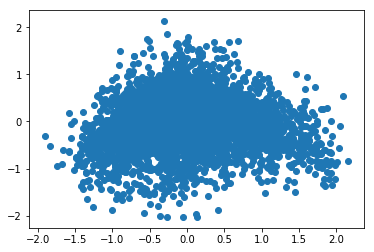

In [78]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
X = skg[skg.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
pyplot.scatter(result[:, 0], result[:, 1])

In [79]:
keys = ['diagnoses', 'treatment', 'days', 'criteria', 'pregnant', 'normal',
        'female', 'male', 'liver', 'childbearing', 'contraception', 'visit',
        'carcinoma', 'cancer', 'drugs']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in skg.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(skg[similar_word])
    embedding_clusters.append(embeddings)
word_clusters.append(words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [0]:
from sklearn.manifold import TSNE
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

### Visualizing vectors similar to "diagnoses"

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


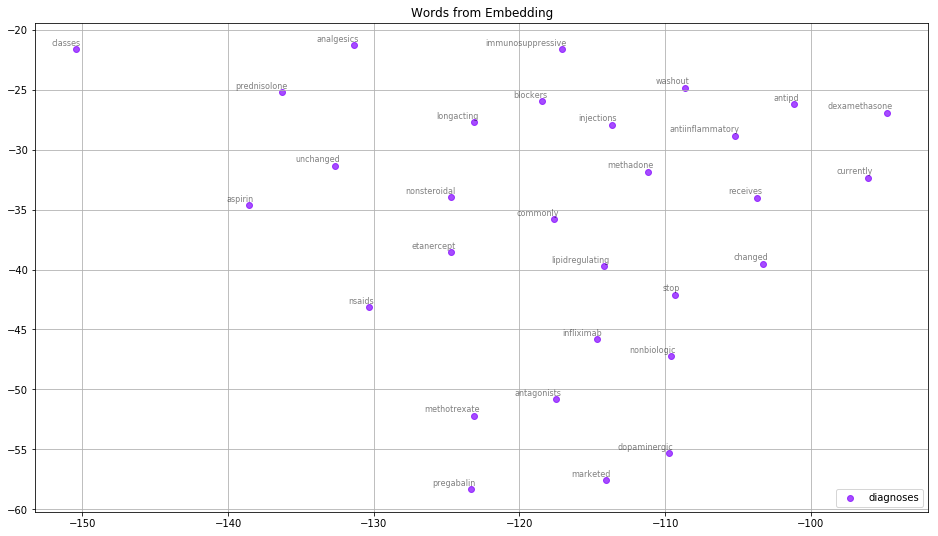

In [81]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Words from Embedding', keys, embeddings_en_2d, 
                        word_clusters, 0.7,'words.png')

# Classification of Elgibility Criteria realated to Breast Cancer and Alzheimers

The training set consists of eligibility criteria for breast cancer and Alzheimer's disease.
Using the word embeddings, an LSTM model is trained to distinguish between Breast Cancer and Alzheimer's

## Read Data

### Training Data

In [82]:
f = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TrainingData.txt",sep='\t')
txt_alz = f[f['disease'].isin(['alz']) & f['type'].isin(['inclusion'])].txt.tolist()
txt_bc = f[f['disease'].isin(['bc']) & f['type'].isin(['inclusion'])].txt.tolist()
f.head()

,nct_id,disease,type,txt
0,NCT00034762,alz,inclusion,A diagnosis of dementia of the Alzheimer's typ...
1,NCT00034762,alz,exclusion,Disease that could significantly diminish cogn...
2,NCT00034762,alz,exclusion,history of neuroleptic malignant syndrome
3,NCT00034762,alz,exclusion,hypersensitivity to risperidone.
4,NCT00034762,alz,inclusion,Residents of nursing homes or long-term care f...


### Test Data

In [0]:
f = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TestData.txt",sep='\t',encoding='iso-8859-1')
t_alz = f[f['disease'].isin(['alz']) & f['type'].isin(['inclusion'])].txt.tolist()
t_bc = f[f['disease'].isin(['bc']) & f['type'].isin(['inclusion'])].txt.tolist()


### Clean, Tokenize and filter

In [0]:
from itertools import compress
def cleanText(t):
  """
  Cleans text and tokenizes the strings
  """
  #convert to lower case
  txt1 = list(map(lambda x: x.lower(), t))
  #Keep only non-Alphanumeric [^a-zA-Z0-9_]
  txt2 = list(map(lambda x: re.sub(r'\w*\d\w*', " ",x), txt1))
  txt3 = list(map(lambda x: re.sub(r'[^a-z ]+', '', x), txt2))
  #txt2 = list(map(lambda x: re.sub('\W+', " ",x), txt1))
  #Remove words < 4 characters
  txt4 = list(map(lambda x: re.sub(r'\b\w{1,3}\b', '', x),txt3))
  #Remove Extra Spaces
  txt5 = list(map(lambda x: re.sub('\s+', ' ', x).strip(),txt4))
  txt6 = [nltk.word_tokenize(x) for x in txt5]
  return(txt6)

def restrictVocab(t,vocab):
  """
  Restricting the text to tokens in the Word Embedding
  """
  x1 = [list(set(x)& set(vocab)) for x in t]
  l = [len(x)>3 for x in x1]
  t = list(compress(x1, l))
  return(t)
  

In [85]:
x = cleanText(txt_alz)
alz = restrictVocab(x,vocab)
x = cleanText(txt_bc)
bc = restrictVocab(x,vocab)
print("Number of Training samples for Alzheimer's = ",len(alz))
print("Number of Training samples for Breast Cancer = ",len(bc))

Number of Training samples for Alzheimer's =  1915
Number of Training samples for Breast Cancer =  542


In [86]:
import random
x = cleanText(t_alz)
t_alz = restrictVocab(x,vocab)
x = cleanText(t_bc)
t_bc = restrictVocab(x,vocab)
t_bc = random.sample(t_bc, len(t_alz))
print("Number of Test samples for Alzheimer's = ",len(t_alz))
print("Number of Test samples for Breast Cancer = ",len(t_bc))

Number of Test samples for Alzheimer's =  304
Number of Test samples for Breast Cancer =  304


In [87]:
len(t_bc)

304

## Vectorizing Data


### Converting sequences to vectors

In [0]:
def word2token(model,word):
  
  """
  Given the word, returns the index of the word
  """
  try:
    return model.wv.vocab[word].index
  except KeyError:
    return 0
def token2word(model,token):
  
  """
  Given an index, retuns the word
  """
  return model.wv.index2word[token]


class SequenceIterator:
  
  """
  To create vectors from sequences
  """
  def __init__(self, dataset, seq_length,model):
    self.dataset = dataset
    self.seq_length = seq_length
    self.model = model

  def __iter__(self):
    for news in self.dataset:
      words = np.array([word2token(self.model,w) for w in news.split(' ')[:self.seq_length] if w != ''])                   
      yield (words)

In [89]:
print(word2token(skg,"diagnoses"))
print(token2word(skg,1684))

1684
diagnoses


#### Training Set

In [90]:
import random
MAX_SEQUENCE_LENGTH = 10
z1 = [' '.join(elem) for elem in alz]
z2 = [' '.join(elem) for elem in bc]
z = z1 + z2

sequences = SequenceIterator(z, MAX_SEQUENCE_LENGTH,skg)
set_x = []
for w in sequences:
    set_x.append(w)
len(z)

# Padding sequences with 0.
x_train = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
y_train = np.array([0]*len(alz)+[1]*len(bc))
print(x_train.shape)
print(y_train.shape)

VALID_PER = 0.20 # Percentage of the whole set that will be separated for validation

total_samples = x_train.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

random_i = random.sample(range(total_samples), total_samples)
train_x = x_train[random_i[:n_train]]
train_y = y_train[random_i[:n_train]]
val_x = x_train[random_i[n_train:n_train+n_val]]
val_y = y_train[random_i[n_train:n_train+n_val]]

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

(2457, 10)
(2457,)
Train Shapes - X: (1966, 10) - Y: (1966,)
Val Shapes - X: (491, 10) - Y: (491,)


#### Test Set

In [91]:
z1 = [' '.join(elem) for elem in t_alz]
z2 = [' '.join(elem) for elem in t_bc]
z = z1 + z2

sequences = SequenceIterator(z, MAX_SEQUENCE_LENGTH,skg)
set_x = []
for w in sequences:
    set_x.append(w)
len(z)

# Padding sequences with 0.
x_test = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
y_test = np.array([0]*len(z1)+[1]*len(z2))
print(x_test.shape)
print(y_test.shape)

(608, 10)
(608,)


## Model

In [92]:
w2v_weights = skg.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 6438 - Embedding Dim: 100


### Bi-Directional LSTM

In [0]:
m_bi = Sequential()
# Keras Embedding layer with Word2Vec weights initialization
m_bi.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

m_bi.add(Bidirectional(LSTM(100)))
#m_bi.add(Bidirectional(LSTM(100)))
m_bi.add(Dense(1, activation='sigmoid'))
m_bi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = 'biLSTM.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
his_bi = m_bi.fit(x_train, y_train, epochs=50, batch_size=64,
                  validation_data=(val_x, val_y), verbose=False,
                  callbacks=[early_stopping, model_checkpoint])

#### Performance on Test Set

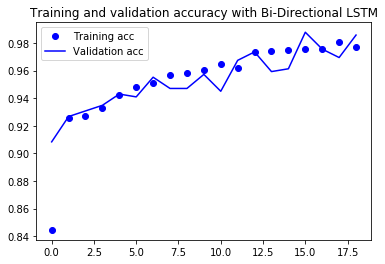

In [94]:
acc = his_bi.history['acc']
val_acc = his_bi.history['val_acc']
loss = his_bi.history['loss']
val_loss = his_bi.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with Bi-Directional LSTM')
plt.legend()

In [95]:
from sklearn.metrics import accuracy_score
y = m_bi.predict_classes(x_test)
yhat = y[:, 0]
biLSTM_acc = accuracy_score(y_test, yhat)
print('Bi-Directional LSTM Accuracy: %f' % biLSTM_acc)

Bi-Directional LSTM Accuracy: 0.930921


### LSTM

In [0]:
m_lstm = Sequential()
# Keras Embedding layer with Word2Vec weights initialization
m_lstm.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

m_lstm.add(LSTM(100))
m_lstm.add(Dense(1, activation='sigmoid'))
m_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = 'LSTM.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
his_lstm = m_lstm.fit(x_train, y_train, epochs=50, batch_size=64,
                  validation_data=(val_x, val_y), verbose=False,
                  callbacks=[early_stopping, model_checkpoint])


#### Performance on Test Set



LSTM Accuracy: 0.924342


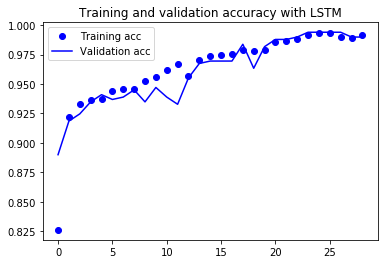

In [97]:
acc = his_lstm.history['acc']
val_acc = his_lstm.history['val_acc']
loss = his_lstm.history['loss']
val_loss = his_lstm.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with LSTM')
plt.legend()

y = m_lstm.predict_classes(x_test)
yhat = y[:, 0]
LSTM_acc = accuracy_score(y_test, yhat)
print('LSTM Accuracy: %f' % LSTM_acc)

### RNN

In [0]:
m_rnn = Sequential()
# Keras Embedding layer with Word2Vec weights initialization
m_rnn.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

m_rnn.add(SimpleRNN(100))
m_rnn.add(Dense(1, activation='sigmoid'))
m_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = 'RNN.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
his_rnn = m_rnn.fit(x_train, y_train, epochs=50, batch_size=64,
                  validation_data=(val_x, val_y), verbose=False,
                  callbacks=[early_stopping, model_checkpoint])


#### Performance on Test Set

RNN_accuracy: 0.884868


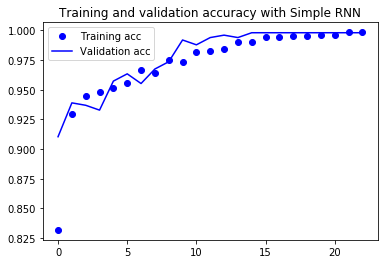

In [99]:
acc = his_rnn.history['acc']
val_acc = his_rnn.history['val_acc']
loss = his_rnn.history['loss']
val_loss = his_rnn.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with Simple RNN')
plt.legend()

y = m_rnn.predict_classes(x_test)
yhat = y[:, 0]
RNN_acc = accuracy_score(y_test, yhat)
print('RNN_accuracy: %f' % RNN_acc)

### Without Word Embedding

In [100]:
m_nn = Sequential()
# Keras Embedding layer with Word2Vec weights initialization
m_nn.add(Embedding(input_dim=vocab_size, output_dim=embedding_size,input_length=MAX_SEQUENCE_LENGTH))
m_nn.add(Flatten())
m_nn.add(Dense(40,activation='relu'))
m_nn.add(Dense(40,activation='relu'))
m_nn.add(Dense(1, activation='sigmoid'))
m_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

his_nn = m_nn.fit(x_train, y_train, epochs=50, batch_size=64,
                  validation_data=(val_x, val_y), verbose=1)

Train on 2457 samples, validate on 491 samples
Epoch 1/50
2457/2457 [==============================] - 4s 2ms/step - loss: 0.5949 - acc: 0.7306 - val_loss: 0.4656 - val_acc: 0.7760
Epoch 2/50
2457/2457 [==============================] - 0s 70us/step - loss: 0.3071 - acc: 0.8486 - val_loss: 0.1669 - val_acc: 0.9613
Epoch 3/50
2457/2457 [==============================] - 0s 68us/step - loss: 0.0841 - acc: 0.9731 - val_loss: 0.0356 - val_acc: 0.9878
Epoch 4/50
2457/2457 [==============================] - 0s 68us/step - loss: 0.0208 - acc: 0.9931 - val_loss: 0.0116 - val_acc: 0.9959
Epoch 5/50
2457/2457 [==============================] - 0s 68us/step - loss: 0.0074 - acc: 0.9992 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 6/50
2457/2457 [==============================] - 0s 76us/step - loss: 0.0046 - acc: 0.9988 - val_loss: 0.0046 - val_acc: 0.9980
Epoch 7/50
2457/2457 [==============================] - 0s 71us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0112 - val_acc: 0.9959
Epoch 8/5

#### Performance on Test Set

In [101]:
y = m_nn.predict_classes(x_test)
yhat = y[:, 0]
NoEmbed_acc = accuracy_score(y_test, yhat)
print('NN_accuracy: %f' % NoEmbed_acc)

NN_accuracy: 0.896382


# Evaluation

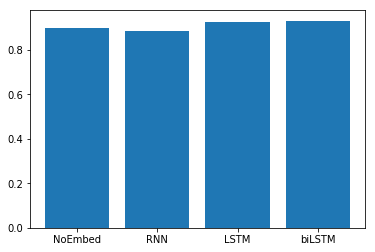

In [107]:
x = np.arange(4)
plt.bar(x,[NoEmbed_acc,RNN_acc,LSTM_acc,biLSTM_acc])
plt.xticks(x, ('NoEmbed', 'RNN', 'LSTM', 'biLSTM'))
plt.show()

In [109]:
print("Accuracy without using Word Embedding = ",nn_acc)
print("Accuracy using Word Embedding + BiDirectional LSTM = ",biLSTM_acc)
print("Accuracy using Word Embedding + RNN = ",RNN_acc)
print("Accuracy using Word Embedding + LSTM = ",LSTM_acc)


Accuracy without using Word Embedding =  0.8842105263157894
Accuracy using Word Embedding + BiDirectional LSTM =  0.930921052631579
Accuracy using Word Embedding + RNN =  0.8848684210526315
Accuracy using Word Embedding + LSTM =  0.9243421052631579
